# 환경설정

In [1]:
!pip install langchain langgraph typing typing_extensions langchain_core langchain-community -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 16.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
import os
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 간단한 그래프

## State 정의
- 그래프의 노드의 입력과 출력 관리하는 딕셔너리 형태의 자료형
- 그래프를 통과하며, 컨텍스트를 유지 (각 노드는 입력과 출력을 State에 담아 처리)
- typing 모듈의 TypedDict 클래스를 사용.

In [6]:
from typing import TypedDict

# 그래프 전체에서 주고받는 데이터 구조를 정의
class State(TypedDict):
    text: str
    extra_field: int

## Node 정의
- 입력 : State 구조
- 출력 : State 구조

In [7]:
def node_1(state: State):
    print(state)
    # 입력: 상태 (state) → text 필드에 문자열을 덧붙임
    # extra_field은 무조건 10으로 덮어씀
    return {"text": state['text'] + "(텍스트 추가됨)", "extra_field": 10}

## 그래프 정의

In [8]:
from langgraph.graph import StateGraph, START, END

# 그래프 초기화
builder = StateGraph(State)

# Node 추가
builder.add_node("node", node_1)  # "node"라는 이름으로 node_1 함수를 노드로 추가

# 노드 연결
builder.add_edge(START, "node")
builder.add_edge("node", END)

# 그래프 컴파일
graph = builder.compile()

### 그래프 시각화

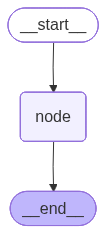

In [9]:
graph

## Graph 실행
- 입력 : State 딕셔너리 형식. 특정 키만 입력 가능
- 출력 : State 딕셔너리 형식.

In [10]:
graph.invoke({"text" : "안녕!"})

{'text': '안녕!'}


{'text': '안녕!(텍스트 추가됨)', 'extra_field': 10}

## 실습1

다음과 같은 그래프를 구축해 봅시다.
* node_1 : 위 함수 그대로 사용 가능
* node_2 : node_1을 그대로 사용해도 되고, 조금 변형해도 됨.

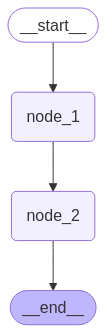

### State 정의

In [11]:
class State(TypedDict):
    text: str
    extra_field: int

### Node 정의

In [13]:
# 노드 1: 텍스트에 문장 추가 + 필드 값 고정
def node_1(state: State):
    print("node_1 실행 전:", state)

    new_state = {
        "text": state["text"] + " → node_1에서 추가됨",
        "extra_field": 10
    }

    print("node_1 실행 후:", new_state)
    return new_state

# 노드 2: 텍스트에 추가 + 필드 증가
def node_2(state: State):
    print("node_2 실행 전:", state)

    # 기존 값 가져오기
    current_text = state.get("text", "")
    current_extra = state.get("extra_field", 0)

    # 새로운 상태 생성
    new_state = {
        "text": current_text + " → node_2에서 추가됨",
        "extra_field": current_extra + 5
    }

    print("node_2 실행 후:", new_state)
    return new_state


### 그래프 정의

In [14]:
from langgraph.graph import StateGraph, END

# 1. 그래프 빌더 생성
builder = StateGraph(State)

# 2. 노드 등록
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# 3. 엣지 연결: START → node_1 → node_2 → END
builder.add_edge("__start__", "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# 4. 그래프 컴파일
graph = builder.compile()


### 그래프 시각화

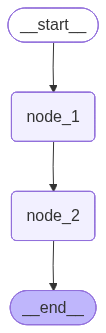

In [15]:
graph

### graph 실행

In [16]:
# 실행
initial_state = {"text": "처음 시작", "extra_field": 0}

result = graph.invoke(initial_state)
print("최종 결과:", result)

node_1 실행 전: {'text': '처음 시작', 'extra_field': 0}
node_1 실행 후: {'text': '처음 시작 → node_1에서 추가됨', 'extra_field': 10}
node_2 실행 전: {'text': '처음 시작 → node_1에서 추가됨', 'extra_field': 10}
node_2 실행 후: {'text': '처음 시작 → node_1에서 추가됨 → node_2에서 추가됨', 'extra_field': 15}
최종 결과: {'text': '처음 시작 → node_1에서 추가됨 → node_2에서 추가됨', 'extra_field': 15}


## 실습2
* 입력값에 연산을 반복 적용하는 단방향 그래프를 만들어보자.
* 사용자로부터 숫자 하나를 입력받아, 다음 연산을 순서대로 수행하는 그래프(아래 그래프)를 구현하시오
    * 각 연산은 독립된 노드로 만들기 (double, square, add_five)
    * 최종 결과는 result 노드에서 출력되도록 구성
    * 상태 구조: {"value": 입력값} 형식 유지

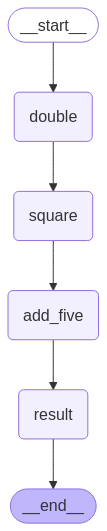

### State 정의

In [17]:
from typing import TypedDict

class State(TypedDict):
    value: int

### Node 정의

In [18]:
# 1) value를 2배로 만드는 노드
def node_double(state: State):
    print("[node_double] 입력:", state)
    new_state = {"value": state["value"] * 2}
    print("[node_double] 출력:", new_state)
    return new_state


# 2) value를 제곱하는 노드
def node_square(state: State):
    print("[node_square] 입력:", state)
    new_state = {"value": state["value"] ** 2}
    print("[node_square] 출력:", new_state)
    return new_state


# 3) value에 5를 더하는 노드
def node_add_five(state: State):
    print("[node_add_five] 입력:", state)
    new_state = {"value": state["value"] + 5}
    print("[node_add_five] 출력:", new_state)
    return new_state


# 4) 최종 결과 출력 노드 (state 출력만 하고 그대로 반환)
def node_result(state: State):
    print("=== 최종 결과 ===")
    print("value =", state["value"])
    return state


### 그래프 정의

In [19]:
builder = StateGraph(State)

# 노드 등록
builder.add_node("double", node_double)
builder.add_node("square", node_square)
builder.add_node("add_five", node_add_five)
builder.add_node("result", node_result)

# 엣지 연결: START → double → square → add_five → result → END
builder.add_edge("double", "square")
builder.add_edge("square", "add_five")
builder.add_edge("add_five", "result")

builder.set_entry_point("double")   # 시작 노드 지정
builder.add_edge("result", END)     # 종료 노드

# 그래프 컴파일
graph = builder.compile()

print("그래프 컴파일 완료!")

그래프 컴파일 완료!


### 그래프 시각화

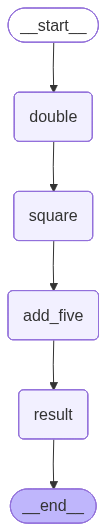

In [20]:
graph

### 그래프 실행

In [21]:
# 실행
input_state = {"value": 3}
graph.invoke(input_state)

[node_double] 입력: {'value': 3}
[node_double] 출력: {'value': 6}
[node_square] 입력: {'value': 6}
[node_square] 출력: {'value': 36}
[node_add_five] 입력: {'value': 36}
[node_add_five] 출력: {'value': 41}
=== 최종 결과 ===
value = 41


{'value': 41}

# State 다루기



## State 값 변화
* 노드 2개: START → node_1 → node_2 → END
* State 필드 4개 사용
    * text: 누적 메시지 기록
    * user_id: 사용자 고유 ID
    * step: 현재 몇 번째 노드인지
    * history: 각 노드 처리 기록 저장 (리스트)

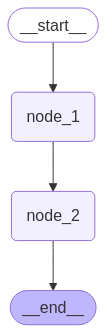

## State 정의

In [22]:
class State(TypedDict):
    text: str
    user_id: str
    step: int
    history: list[str]

## Node 정의

In [23]:
# node_1: 텍스트 변경 + step 증가 + 기록 저장
def node_1(state: State):
    print("node_1 실행 전 상태:", state)

    state["text"] += " → node_1 처리 완료"
    state["step"] += 1
    state["history"].append(f"node_1 완료 (step  {state['step']})")

    print("node_1 실행 후 상태:", state)
    return state

# node_2: 또 한 번 수정 + 기록 누적
def node_2(state: State):
    print("node_2 실행 전 상태:", state)

    state["text"] += " → node_2 처리 완료"
    state["step"] += 1
    state["history"].append(f"node_2 완료 (step {state['step']})")

    print("node_2 실행 후 상태:", state)
    return state

## 그래프 정의

In [24]:
# 그래프 구성
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

graph = builder.compile()

## 그래프 시각화

In [37]:
# 외부 서버를 호출하는 동안 대기시간 초과로 오류가 날 수 있습니다.
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 그래프 실행

In [26]:
# 실행 : 함수로 실행
initial_state = {
    "text": "처음 요청 도착",
    "user_id": "user_1234",
    "step": 0,
    "history": []
}

# node_1
state = node_1(initial_state)
print(f'node_1 : {state}')

# node_1
state = node_2(state)
print(f'node_2 : {state}')

node_1 실행 전 상태: {'text': '처음 요청 도착', 'user_id': 'user_1234', 'step': 0, 'history': []}
node_1 실행 후 상태: {'text': '처음 요청 도착 → node_1 처리 완료', 'user_id': 'user_1234', 'step': 1, 'history': ['node_1 완료 (step  1)']}
node_1 : {'text': '처음 요청 도착 → node_1 처리 완료', 'user_id': 'user_1234', 'step': 1, 'history': ['node_1 완료 (step  1)']}
node_2 실행 전 상태: {'text': '처음 요청 도착 → node_1 처리 완료', 'user_id': 'user_1234', 'step': 1, 'history': ['node_1 완료 (step  1)']}
node_2 실행 후 상태: {'text': '처음 요청 도착 → node_1 처리 완료 → node_2 처리 완료', 'user_id': 'user_1234', 'step': 2, 'history': ['node_1 완료 (step  1)', 'node_2 완료 (step 2)']}
node_2 : {'text': '처음 요청 도착 → node_1 처리 완료 → node_2 처리 완료', 'user_id': 'user_1234', 'step': 2, 'history': ['node_1 완료 (step  1)', 'node_2 완료 (step 2)']}


In [27]:
# 실행 : graph로 실행
initial_state = {
    "text": "처음 요청 도착",
    "user_id": "user_1234",
    "step": 0,
    "history": []
}

result = graph.invoke(initial_state)
print("\n 최종 결과 상태:", result)

node_1 실행 전 상태: {'text': '처음 요청 도착', 'user_id': 'user_1234', 'step': 0, 'history': []}
node_1 실행 후 상태: {'text': '처음 요청 도착 → node_1 처리 완료', 'user_id': 'user_1234', 'step': 1, 'history': ['node_1 완료 (step  1)']}
node_2 실행 전 상태: {'text': '처음 요청 도착 → node_1 처리 완료', 'user_id': 'user_1234', 'step': 1, 'history': ['node_1 완료 (step  1)']}
node_2 실행 후 상태: {'text': '처음 요청 도착 → node_1 처리 완료 → node_2 처리 완료', 'user_id': 'user_1234', 'step': 2, 'history': ['node_1 완료 (step  1)', 'node_2 완료 (step 2)']}

 최종 결과 상태: {'text': '처음 요청 도착 → node_1 처리 완료 → node_2 처리 완료', 'user_id': 'user_1234', 'step': 2, 'history': ['node_1 완료 (step  1)', 'node_2 완료 (step 2)']}


## 실습1
유저 프로필 정보 누적 저장
* 요구사항
    * 그래프 : start → 이름 입력 → 나이 입력 → 이메일 입력 → 출력
        * 유저의 이름, 나이, 이메일 정보를 순차적으로 입력받아 상태(State)에 저장하는 과정을 연습하자.
    * 조건
        * 상태 구조는 {"name": str, "age": int, "email": str}
        * 각 노드는 입력값을 받아 상태에 반영
        * 최종 출력 노드에서 전체 상태를 출력할 것

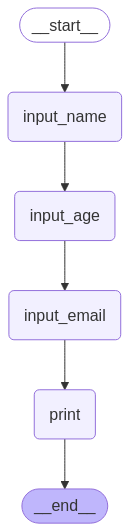

### State 정의

In [39]:
from typing import TypedDict

class State(TypedDict):
    name: str
    age: int
    email: str


### Node 정의

In [40]:
def node_input_name(state: State):
    user_input = input("이름을 입력하세요: ")
    return {"name": user_input, "age": state["age"], "email": state["email"]}


def node_input_age(state: State):
    user_input = int(input("나이를 입력하세요: "))
    return {"name": state["name"], "age": user_input, "email": state["email"]}


def node_input_email(state: State):
    user_input = input("이메일을 입력하세요: ")
    return {"name": state["name"], "age": state["age"], "email": user_input}


def node_result(state: State):
    print("\n=== 최종 사용자 정보 ===")
    print("이름 :", state["name"])
    print("나이 :", state["age"])
    print("이메일 :", state["email"])
    return state


### 그래프 정의

In [41]:
from langgraph.graph import StateGraph, END

# 그래프 생성
builder = StateGraph(State)

# 노드 등록
builder.add_node("input_name", node_input_name)
builder.add_node("input_age", node_input_age)
builder.add_node("input_email", node_input_email)
builder.add_node("result", node_result)

# 엣지 연결: start → 이름 → 나이 → 이메일 → 출력 → END
builder.set_entry_point("input_name")
builder.add_edge("input_name", "input_age")
builder.add_edge("input_age", "input_email")
builder.add_edge("input_email", "result")
builder.add_edge("result", END)

# 그래프 컴파일
graph = builder.compile()

print("그래프 빌드 완료!")


그래프 빌드 완료!


### 그래프 시각화

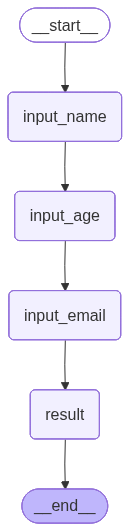

In [42]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Mermaid 렌더링 오류:", e)


### 그래프 실행

In [32]:
initial_state = {"name": "", "age": 0, "email": ""}

graph.invoke(initial_state)


이름을 입력하세요: 최규영
나이를 입력하세요: 25
이메일을 입력하세요: choi25@naver.com

=== 최종 사용자 정보 ===
이름 : 최규영
나이 : 25
이메일 : choi25@naver.com


{'name': '최규영', 'age': 25, 'email': 'choi25@naver.com'}

## 실습2

* 요구사항
    * 노드 2개를 만들고, START → node_1 → node_2 → END 흐름으로 연결하시오.
    * node_1은 다음을 수행:
        * "score"에 10을 추가
        * "log"에 "node_1 completed"를 추가

    * node_2는 다음을 수행:
        * "score"에 5를 추가
        * "log"에 "node_2 completed"를 추가

    * 각 node_1, node_2의 실행 결과(state)를 출력하시오.
    * 최종 상태를 출력하시오.

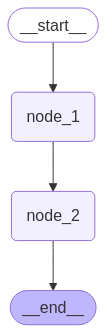

### State 정의

In [43]:
from typing import TypedDict, List

class State(TypedDict):
    score: int
    log: List[str]


### Node 정의

In [44]:
def node_1(state: State):
    new_state = {
        "score": state["score"] + 10,
        "log": state["log"] + ["node_1 completed"]
    }
    print("node_1 실행 결과:", new_state)
    return new_state


def node_2(state: State):
    new_state = {
        "score": state["score"] + 5,
        "log": state["log"] + ["node_2 completed"]
    }
    print("node_2 실행 결과:", new_state)
    return new_state


### 그래프 정의

In [45]:
from langgraph.graph import StateGraph, END

builder = StateGraph(State)

# 노드 등록
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# 연결: START → node_1 → node_2 → END
builder.set_entry_point("node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# 그래프 컴파일
graph = builder.compile()


### 그래프 시각화

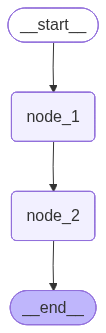

In [46]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Mermaid 렌더링 오류:", e)


### 그래프 실행

In [36]:
initial_state = {"score": 0, "log": []}

final_state = graph.invoke(initial_state)

print("\n=== 최종 상태 ===")
print(final_state)


node_1 실행 결과: {'score': 10, 'log': ['node_1 completed']}
node_2 실행 결과: {'score': 15, 'log': ['node_1 completed', 'node_2 completed']}

=== 최종 상태 ===
{'score': 15, 'log': ['node_1 completed', 'node_2 completed']}


# Routing
* workflow에서 Routing은 매우 중요합니다. *Routing*(라우팅) 은 특정 입력에 따라 서로 다른 경로를 선택하여 실행 흐름을 제어하는 기능입니다.
* 이를 통해 사용자의 입력이나 특정 조건에 따라 서로 다른 노드를 실행할 수 있습니다.

## Conditional Edge

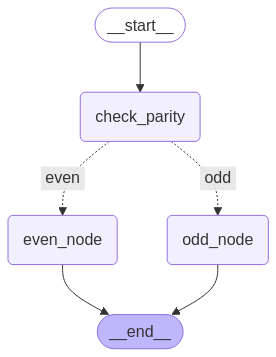

## State 정의

In [47]:
class State(TypedDict):
    number: int
    result: str

## Node 정의

In [48]:
# 노드: 짝/홀수 판별
def check_parity(state: State):
    print(f"check_parity: 입력된 숫자 = {state['number']}")
    return state  # 판단만 하고, 실제 처리는 다음 노드에서 함

# 짝수 노드
def even_node(state: State):
    print("짝수입니다!")
    state["result"] = "짝수입니다!"
    return state

# 홀수 노드
def odd_node(state: State):
    print("홀수입니다!")
    state["result"] = "홀수입니다!"
    return state

## 그래프 정의

In [49]:
# 그래프 생성
builder = StateGraph(State)

# 노드 등록
builder.add_node("check_parity", check_parity)
builder.add_node("even_node", even_node)
builder.add_node("odd_node", odd_node)

# 조건 분기 연결
def parity_condition(state: State):
    return "even" if state["number"] % 2 == 0 else "odd"

builder.add_conditional_edges("check_parity", parity_condition,
                              {"even": "even_node", "odd": "odd_node"}
                              )

# 나머지 연결
builder.add_edge(START, "check_parity")
builder.add_edge("even_node", END)
builder.add_edge("odd_node", END)

# 그래프 컴파일
graph = builder.compile()

## 그래프 시각화

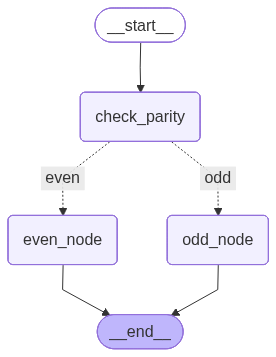

In [50]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Mermaid 렌더링 오류:", e)

## 그래프 실행

In [51]:
state = {"number": 7, "result": ""}
result = graph.invoke(state)
print("최종 결과:", result)

check_parity: 입력된 숫자 = 7
홀수입니다!
최종 결과: {'number': 7, 'result': '홀수입니다!'}


## 실습1

* check_score: 분기 기준 판단만 하고 상태는 변경하지 않음
* pass_node: "result"에 "합격" 저장
* fail_node: "result"에 "불합격" 저장

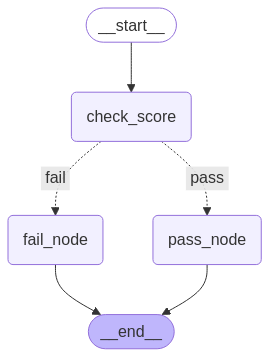

### State 정의

In [53]:
from typing import TypedDict, Optional

class State(TypedDict):
    score: int
    result: Optional[str]



### Node 정의

In [54]:
def check_score(state: State):
    print("check_score 실행:", state)
    return state
def pass_node(state: State):
    new_state = {
        "score": state["score"],
        "result": "합격"
    }
    print("pass_node 실행:", new_state)
    return new_state

def fail_node(state: State):
    new_state = {
        "score": state["score"],
        "result": "불합격"
    }
    print("fail_node 실행:", new_state)
    return new_state


### 그래프 정의

In [55]:
from langgraph.graph import StateGraph, END

builder = StateGraph(State)

# 노드 등록
builder.add_node("check_score", check_score)
builder.add_node("pass_node", pass_node)
builder.add_node("fail_node", fail_node)

# 엔트리 포인트 설정
builder.set_entry_point("check_score")

# 조건부 라우팅
builder.add_conditional_edges(
    "check_score",
    lambda state: "pass_node" if state["score"] >= 60 else "fail_node",
    {
        "pass_node": "pass_node",
        "fail_node": "fail_node"
    }
)

# 두 노드 종료 연결
builder.add_edge("pass_node", END)
builder.add_edge("fail_node", END)

# 그래프 컴파일
graph = builder.compile()


### 그래프 시각화

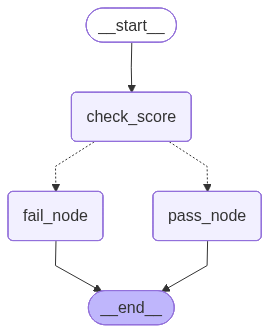

In [56]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("시각화 오류:", e)


### 그래프 실행

In [57]:
initial_state = {"score": 75, "result": None}
final_state = graph.invoke(initial_state)

print("\n최종 상태:", final_state)


check_score 실행: {'score': 75, 'result': None}
pass_node 실행: {'score': 75, 'result': '합격'}

최종 상태: {'score': 75, 'result': '합격'}


In [58]:
initial_state = {"score": 50, "result": None}
final_state = graph.invoke(initial_state)

print("\n최종 상태:", final_state)


check_score 실행: {'score': 50, 'result': None}
fail_node 실행: {'score': 50, 'result': '불합격'}

최종 상태: {'score': 50, 'result': '불합격'}


## (3) 실습2

* 목표 : 사용자의 감정을 판단해 다른 응답을 출력하는 조건 분기 라우팅 그래프 만들기

* 문제 설명 : 사용자로부터 입력받은 감정(문자열 "happy", "sad", "angry")에 따라 다른 노드를 호출하는 그래프를 만드시오.

* 조건:
    * 상태는 {"emotion": str, "response": str}
    * router 노드가 emotion 값을 기반으로 "happy", "sad", "angry" 중 하나의 노드로 분기
    * 각 감정 노드는 감정에 맞는 위로 또는 축하 메시지를 출력

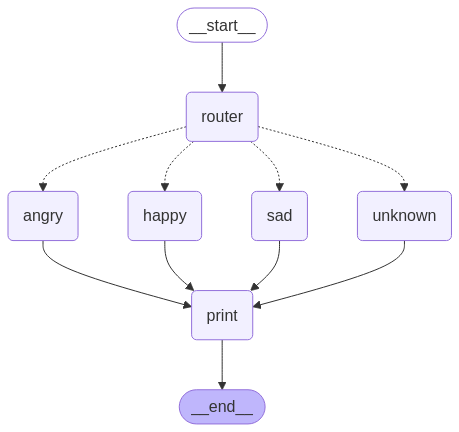

### State 정의

In [59]:
from typing import TypedDict, Optional

class State(TypedDict):
    emotion: str
    response: Optional[str]


### Node 정의

In [60]:
def router(state: State):
    print("router 실행:", state)
    return state
def happy_node(state: State):
    new_state = {
        "emotion": state["emotion"],
        "response": "좋은 일이 있었나 봐요! 정말 축하해요 😊"
    }
    print("happy_node 실행:", new_state)
    return new_state
def sad_node(state: State):
    new_state = {
        "emotion": state["emotion"],
        "response": "괜찮아요… 힘들었겠네요. 제가 함께할게요 😢"
    }
    print("sad_node 실행:", new_state)
    return new_state
def angry_node(state: State):
    new_state = {
        "emotion": state["emotion"],
        "response": "많이 불편하셨겠어요. 함께 진정해봐요 😤"
    }
    print("angry_node 실행:", new_state)
    return new_state


### 그래프 정의

In [61]:
from langgraph.graph import StateGraph, END

builder = StateGraph(State)

# 노드 등록
builder.add_node("router", router)
builder.add_node("happy", happy_node)
builder.add_node("sad", sad_node)
builder.add_node("angry", angry_node)

# 시작 노드
builder.set_entry_point("router")

# 감정에 따른 조건 분기
builder.add_conditional_edges(
    "router",
    lambda state: state["emotion"],   # emotion 값 그대로 반환
    {
        "happy": "happy",
        "sad": "sad",
        "angry": "angry"
    }
)

# 각 감정 노드를 종료로 연결
builder.add_edge("happy", END)
builder.add_edge("sad", END)
builder.add_edge("angry", END)

# 그래프 컴파일
graph = builder.compile()


### 그래프 시각화

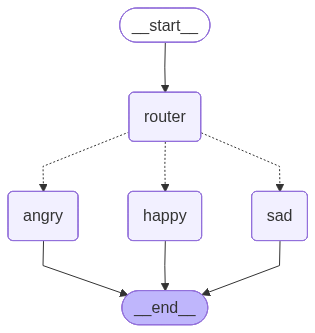

In [62]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("시각화 오류:", e)


### 그래프 실행

In [63]:
initial = {"emotion": "happy", "response": None}
final = graph.invoke(initial)
print("\n최종:", final)


router 실행: {'emotion': 'happy', 'response': None}
happy_node 실행: {'emotion': 'happy', 'response': '좋은 일이 있었나 봐요! 정말 축하해요 😊'}

최종: {'emotion': 'happy', 'response': '좋은 일이 있었나 봐요! 정말 축하해요 😊'}


In [64]:
initial = {"emotion": "sad", "response": None}
final = graph.invoke(initial)
print("\n최종:", final)


router 실행: {'emotion': 'sad', 'response': None}
sad_node 실행: {'emotion': 'sad', 'response': '괜찮아요… 힘들었겠네요. 제가 함께할게요 😢'}

최종: {'emotion': 'sad', 'response': '괜찮아요… 힘들었겠네요. 제가 함께할게요 😢'}


In [65]:
initial = {"emotion": "angry", "response": None}
final = graph.invoke(initial)
print("\n최종:", final)


router 실행: {'emotion': 'angry', 'response': None}
angry_node 실행: {'emotion': 'angry', 'response': '많이 불편하셨겠어요. 함께 진정해봐요 😤'}

최종: {'emotion': 'angry', 'response': '많이 불편하셨겠어요. 함께 진정해봐요 😤'}


# Reflection

##reflect_node

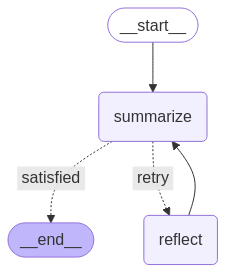

## State 정의

* input: 사용자의 입력
* summary: 요약된 결과 (간단하게 하드코딩 처리)
* is_satisfied: 결과에 만족했는지 여부
* log: 상태 변화를 기록하는 로그

In [66]:
class State(TypedDict):
    input: str
    summary: str
    is_satisfied: bool
    log: list[str]

## Node 정의

In [67]:
# 요약 노드: 간단히 결과 요약 + 만족 여부 결정
def summary_node(state: State):
    state["summary"] += " → 요약됨"
    state["log"].append("요약 수행")

    # 만족 여부 판단 (2회 이상 요약되면 만족했다고 가정)
    if state["summary"].count("요약됨") >= 2:
        state["is_satisfied"] = True
    else:
        state["is_satisfied"] = False
    print(state)
    return state

# 반추 노드: 추가 아이디어 도출 시도 (다시 생각해보기)
def reflect_node(state: State):
    state["log"].append("반추 수행")
    state["summary"] += " → 다시 생각해봄"
    print(state)
    return state

## 그래프 정의

In [68]:
# 그래프 구성
builder = StateGraph(State)
builder.add_node("summarize", summary_node)
builder.add_node("reflect", reflect_node)

# 흐름 정의
builder.add_edge(START, "summarize")

# 조건 분기: 만족 여부에 따라 흐름 결정
def check_satisfaction(state: State):
    return "satisfied" if state["is_satisfied"] else "retry"

builder.add_conditional_edges("summarize", check_satisfaction,
                              {"satisfied": END, "retry": "reflect"})

# 반추 후 → 요약 다시 시도 (루프)
builder.add_edge("reflect", "summarize")

# 컴파일
graph = builder.compile()

## 그래프 시각화

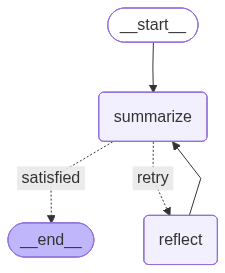

In [69]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 그래프 실행

In [70]:
# 실행
initial_state = {"input": "오늘 하루 요약해줘", "summary": "", "is_satisfied": False, "log": [] }

result = graph.invoke(initial_state)
print("최종 상태:")
print(result)

{'input': '오늘 하루 요약해줘', 'summary': ' → 요약됨', 'is_satisfied': False, 'log': ['요약 수행']}
{'input': '오늘 하루 요약해줘', 'summary': ' → 요약됨 → 다시 생각해봄', 'is_satisfied': False, 'log': ['요약 수행', '반추 수행']}
{'input': '오늘 하루 요약해줘', 'summary': ' → 요약됨 → 다시 생각해봄 → 요약됨', 'is_satisfied': True, 'log': ['요약 수행', '반추 수행', '요약 수행']}
최종 상태:
{'input': '오늘 하루 요약해줘', 'summary': ' → 요약됨 → 다시 생각해봄 → 요약됨', 'is_satisfied': True, 'log': ['요약 수행', '반추 수행', '요약 수행']}


## 실습1
* 사용자가 오타가 있는 문장을 입력했을 때,
    * 에이전트가 그것을 수정 → 검사 → 수정 → 검사…
    * 하면서 "이제 충분히 고쳐졌다고 판단되면 종료"하는 구조를 만든다.

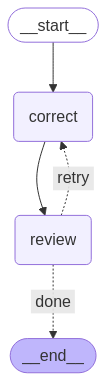

### State 정의

In [74]:
from typing import TypedDict, Optional

class State(TypedDict):
    text: str            # 현재 문장
    prev_text: str       # 이전 단계 문장(변화 여부 체크용)
    is_fixed: bool       # 종료 여부
    iteration: int       # 반복 횟수
    max_iter: int        # 안전장치
    next: str

### Node 정의

In [97]:
def fix_node(state: State):
    text = state["text"]

    # 단순 오타 교정 규칙 예시
    fixed = (
        text.replace("안녀하ㅔ요", "안녕하세요")
            .replace("몰르", "모르")
            .replace("겟습", "겠습")
            .replace("잇ㅅ", "있")
            .replace("니당", "니다")
    )

    state["prev_text"] = state["text"]
    state["text"] = fixed
    state["iteration"] += 1
    return state



def check_node(state: State):

    # 종료조건 1: 반복 횟수 초과
    if state["iteration"] >= state["max_iter"]:
        state["is_fixed"] = True
        state["next"] = "end"
        return state

    # 종료조건 2: 문장이 더 이상 변하지 않음
    if state["text"] == state["prev_text"]:
        state["is_fixed"] = True
        state["next"] = "end"
        return state

    # 계속 반복
    state["next"] = "fix"
    return state



def end_node(state: State):
    return state


### 그래프 정의

In [98]:
from langgraph.graph import StateGraph

graph = StateGraph(State)

graph.add_node("fix", fix_node)
graph.add_node("check", check_node)
graph.add_node("end", end_node)

graph.set_entry_point("fix")

# fix → check
graph.add_edge("fix", "check")

# check → fix / end 조건부 분기
graph.add_conditional_edges(
    "check",
    lambda state: state["next"],    # 분기 기준 필드
    {
        "fix": "fix",
        "end": "end"
    }
)

app = graph.compile()


### 그래프 시각화

In [104]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


### 그래프 실행

In [100]:
initial_state = {
    "text": "안녀하ㅔ요 저는 파이썬을 잘 몰르지만 배워보겟습니당",
    "prev_text": "",
    "is_fixed": False,
    "iteration": 0,
    "max_iter": 10,
    "next": ""
}

result = app.invoke(initial_state)

print("최종 결과:", result)
print("\n최종 문장:", result["text"])


최종 결과: {'text': '안녕하세요 저는 파이썬을 잘 모르지만 배워보겠습니다', 'prev_text': '안녕하세요 저는 파이썬을 잘 모르지만 배워보겠습니다', 'is_fixed': True, 'iteration': 2, 'max_iter': 10}

최종 문장: 안녕하세요 저는 파이썬을 잘 모르지만 배워보겠습니다


## 실습2

* 수 맞히기 게임
    * 랜덤 숫자(1~10)를 입력받아 맞힐 때까지 계속 추측하는 루프 구조 만들기
        * 노드의 실행 결과에 따라 같은 노드를 한 번 더 실행하거나,
        * 특정 조건을 만족하면 종료하거나 다른 노드로 이동할 수 있음
        * 흔히 쓰는 구조
            * judge 노드가 "retry" vs "next" 판단
            * → "retry"면 앞 노드로 되돌아가서 루프
            * → "next"면 다음 노드로 진행

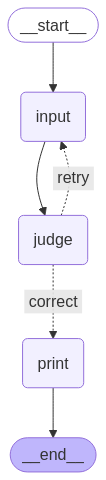

### State 정의

In [105]:
from typing import TypedDict

class State(TypedDict):
    target: int       # 맞혀야 하는 숫자
    guess: int        # 사용자가 입력한 숫자
    result: str       # judge 결과 ("retry" or "next")


### Node 정의

In [111]:
def guess_node(state: State):
    print("\n--- Guess Node ---")
    user_input = int(input("숫자를 입력하세요 (1~10): "))
    state["guess"] = user_input
    return state
def judge_node(state: State):
    print("--- Judge Node ---")

    if state["guess"] == state["target"]:
        print("정답입니다!")
        state["result"] = "next"
    elif state["guess"] > state['target']:
        print('정답보다 큽니다! 다시 시도하세요.')
    else:
        print("정답보다 작습니다! 다시 시도하세요.")
        state["result"] = "retry"
    return state
def end_node(state: State):
    print("\n🎉 게임 종료! 정답:", state["target"])
    return state


### 그래프 정의

In [112]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(State)

# 노드 등록
graph.add_node("guess", guess_node)
graph.add_node("judge", judge_node)
graph.add_node("end", end_node)

# 엣지 연결
graph.add_edge(START, "guess")
graph.add_edge("guess", "judge")

# judge → guess (retry)
graph.add_conditional_edges(
    "judge",
    lambda state: state["result"],
    {
        "retry": "guess",
        "next": "end"
    }
)

graph.add_edge("end", END)

app = graph.compile()


### 그래프 시각화

### 그래프 실행

In [113]:
import random

initial_state = {
    "target": random.randint(1, 10),
    "guess": None,
    "result": ""
}

app.invoke(initial_state)


--- Guess Node ---
숫자를 입력하세요 (1~10): 5
--- Judge Node ---
정답보다 작습니다! 다시 시도하세요.

--- Guess Node ---
숫자를 입력하세요 (1~10): 7
--- Judge Node ---
정답보다 작습니다! 다시 시도하세요.

--- Guess Node ---
숫자를 입력하세요 (1~10): 9
--- Judge Node ---
정답보다 큽니다! 다시 시도하세요.

--- Guess Node ---
숫자를 입력하세요 (1~10): 8
--- Judge Node ---
정답입니다!

🎉 게임 종료! 정답: 8


{'target': 8, 'guess': 8, 'result': 'next'}